In [28]:
import os
import numpy as np
import xarray as xr
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV


In [17]:
# Load the NetCDF file
file_path = "LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project1-EDAV/lib/data/NA_data.nc"
ds = xr.open_dataset(file_path)

In [18]:
# Extract relevant variables
time = ds["time"].values
lat = ds["lat"].values
lon = ds["lon"].values
season = ds["season"].values
storm_speed = ds["storm_speed"].values
storm_dir = ds["storm_dir"].values

In [19]:
# Prepare data for XGBoost
track_data = []
target_lat = []
target_lon = []

In [20]:
for i in range(lat.shape[0]):  # Loop over storms
    for j in range(1, lat.shape[1]):  # Skip the first observation for Δ calculation
        if np.isnan(lat[i, j]) or np.isnan(lon[i, j]) or np.isnan(lat[i, j - 1]) or np.isnan(lon[i, j - 1]):
            continue  # Skip missing data

        # Compute latitude and longitude shifts (target variables)
        delta_lat = lat[i, j] - lat[i, j - 1]
        delta_lon = lon[i, j] - lon[i, j - 1]

        # Extract input features
        track_data.append([
            lat[i, j - 1], lon[i, j - 1],  # Previous position
            storm_speed[i, j - 1] if not np.isnan(storm_speed[i, j - 1]) else 0,  # Speed
            storm_dir[i, j - 1] if not np.isnan(storm_dir[i, j - 1]) else 0,  # Direction
            season[i]  # Year/season as a feature
        ])

        # Store corresponding target values
        target_lat.append(delta_lat)
        target_lon.append(delta_lon)

In [21]:
# Convert to NumPy arrays
X = np.array(track_data)
y_lat = np.array(target_lat)
y_lon = np.array(target_lon)

In [22]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_lat, y_test_lat, y_train_lon, y_test_lon = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42
)

In [23]:
# Train XGBoost models for latitude and longitude shifts
xgb_lat = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_lon = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5, learning_rate=0.1)

xgb_lat.fit(X_train, y_train_lat)
xgb_lon.fit(X_train, y_train_lon)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
# Predict on test set
y_pred_lat = xgb_lat.predict(X_test)
y_pred_lon = xgb_lon.predict(X_test)

# Evaluate model performance
mse_lat = mean_squared_error(y_test_lat, y_pred_lat)
mse_lon = mean_squared_error(y_test_lon, y_pred_lon)

print(f"Mean Squared Error for Latitude Shift Prediction: {mse_lat}")
print(f"Mean Squared Error for Longitude Shift Prediction: {mse_lon}")

Mean Squared Error for Latitude Shift Prediction: 0.004176672548055649
Mean Squared Error for Longitude Shift Prediction: 0.0050215651281178


Text(0.5, 1.0, 'Longitude Shift: Actual vs Predicted')

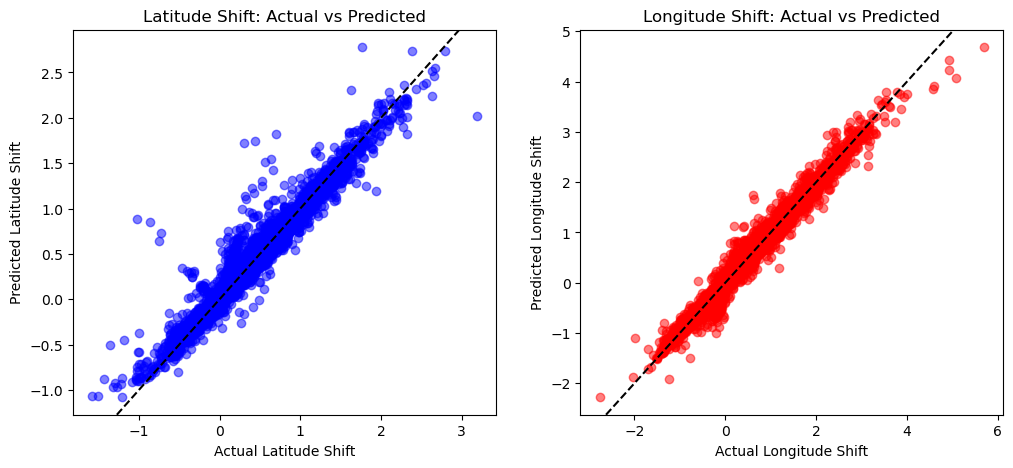

In [32]:
plt.figure(figsize=(12, 5))

# Latitude
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.scatter(y_test_lat, y_pred_lat, alpha=0.5, color="blue")
plt.axline((0, 0), slope=1, color="black", linestyle="--")  # Reference y = x line
plt.xlabel("Actual Latitude Shift")
plt.ylabel("Predicted Latitude Shift")
plt.title("Latitude Shift: Actual vs Predicted")

# Longitude
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.scatter(y_test_lon, y_pred_lon, alpha=0.5, color="red")
plt.axline((0, 0), slope=1, color="black", linestyle="--")  # Reference y = x line
plt.xlabel("Actual Longitude Shift")
plt.ylabel("Predicted Longitude Shift")
plt.title("Longitude Shift: Actual vs Predicted")

In [31]:
# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'min_child_weight': [1, 3, 5, 7]
}

# Perform Randomized Grid Search for latitude shift prediction
xgb_model_lat = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
random_search_lat = RandomizedSearchCV(
    estimator=xgb_model_lat,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42
)
random_search_lat.fit(X_train, y_train_lat)

# Best parameters for latitude
best_params_lat = random_search_lat.best_params_
print("Best Hyperparameters for Latitude:", best_params_lat)

# Train the final XGBoost model for latitude with best parameters
xgb_best_lat = xgb.XGBRegressor(objective="reg:squarederror", **best_params_lat)
xgb_best_lat.fit(X_train, y_train_lat)

# Predict and evaluate the tuned latitude model
y_pred_lat_tuned = xgb_best_lat.predict(X_test)
mse_lat_tuned = mean_squared_error(y_test_lat, y_pred_lat_tuned)
print(f"Mean Squared Error for Tuned Latitude Model: {mse_lat_tuned}")


# Perform Randomized Grid Search for longitude shift prediction
xgb_model_lon = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
random_search_lon = RandomizedSearchCV(
    estimator=xgb_model_lon,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42
)
random_search_lon.fit(X_train, y_train_lon)

# Best parameters for longitude
best_params_lon = random_search_lon.best_params_
print("Best Hyperparameters for Longitude:", best_params_lon)

# Train the final XGBoost model for longitude with best parameters
xgb_best_lon = xgb.XGBRegressor(objective="reg:squarederror", **best_params_lon)
xgb_best_lon.fit(X_train, y_train_lon)

# Predict and evaluate the tuned longitude model
y_pred_lon_tuned = xgb_best_lon.predict(X_test)
mse_lon_tuned = mean_squared_error(y_test_lon, y_pred_lon_tuned)
print(f"Mean Squared Error for Tuned Longitude Model: {mse_lon_tuned}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters for Latitude: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Mean Squared Error for Tuned Latitude Model: 0.0037816064432263374
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters for Longitude: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Mean Squared Error for Tuned Longitude Model: 0.004631730727851391


In [ ]:
from sklearn.model_selection import cross_val_score

# kfold
cv_scores_lat = cross_val_score(
    xgb.XGBRegressor(objective="reg:squarederror"),
    X, y_lat,
    cv=5,  # 5fold
    scoring="neg_mean_squared_error"  # 使用负均方误差（sklearn约定）
)

# average MSE
mse_lat_cv = -cv_scores_lat.mean()
print(f"交叉验证MSE（纬度）: {mse_lat_cv:.4f}")